В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from process_bank_churn import preprocess_data, preprocess_new_data
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('drive/MyDrive/Machine Learning Course/datasources/bank-customer-churn-prediction-dlu/train.csv')

In [42]:
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(df)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [9]:
knn = KNeighborsClassifier().fit(X_train, train_targets)

In [14]:
train_preds = knn.predict_proba(X_train)[:, 1]
val_preds = knn.predict_proba(X_val)[:, 1]

auc_train = roc_auc_score(train_targets, train_preds)
auc_val = roc_auc_score(val_targets, val_preds)

print(auc_train, auc_val)

0.955875881017124 0.8524864531174978


Загалом, можу сказати, що модель не дуже хороша: немає high bias, але наявне high variance, проте на валідаційних даних AUC менший, отже, модель більше під тренувальні дані налаштовується (є перенавчання).

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [16]:
knn_gs = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1, 25)}
gs = GridSearchCV(knn_gs, knn_params, cv=5, scoring='roc_auc')
gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='roc_auc')

In [17]:
knn_best = gs.best_estimator_

train_preds_best = knn_best.predict_proba(X_train)[:, 1]
val_preds_best = knn_best.predict_proba(X_val)[:, 1]

auc_train_best = roc_auc_score(train_targets, train_preds_best)
auc_val_best = roc_auc_score(val_targets, val_preds_best)

print(auc_train_best, auc_val_best)

0.9227154307191971 0.8908176143768434


Поточна модель краща за попередню (вже немає перенавчання), але при цьому трохи гірша, ніж дерева прийняття рішень.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [20]:
model_tree = DecisionTreeClassifier(random_state=42)

In [26]:
%%time
tree_gs = GridSearchCV(
    model_tree,
    {
        'max_depth': np.arange(1, 20, 2),
        'max_leaf_nodes': np.arange(2, 10)
    },
    scoring='roc_auc',
    cv=3
).fit(X_train, train_targets)

CPU times: user 5.61 s, sys: 2.85 ms, total: 5.61 s
Wall time: 5.62 s


In [27]:
tree_gs.best_params_

{'max_depth': np.int64(5), 'max_leaf_nodes': np.int64(9)}

In [29]:
dt_best = tree_gs.best_estimator_

train_preds_dt = dt_best.predict_proba(X_train)[:, 1]
val_preds_dt = dt_best.predict_proba(X_val)[:, 1]

auc_train_dt = roc_auc_score(train_targets, train_preds_dt)
auc_val_dt = roc_auc_score(val_targets, val_preds_dt)

print(auc_train_dt, auc_val_dt)

0.9001138615074584 0.898395980519926


Якість моделі така сама, як і в попередньому пункті (найкраща knn модель).
Ця модель незначно гірша за ту, що я знайшла вручну (оскільки max_leaf_nodes був більший за 10).

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [30]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [32]:
model_tree = DecisionTreeClassifier(random_state=42)

In [35]:
%%time
tree_rs = RandomizedSearchCV(
    model_tree,
    params_dt,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    random_state=0
).fit(X_train, train_targets)

CPU times: user 1.74 s, sys: 3.89 ms, total: 1.75 s
Wall time: 1.83 s


In [36]:
tree_rs.best_params_

{'splitter': 'best',
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': np.int64(19),
 'max_features': None,
 'max_depth': np.int64(16),
 'criterion': 'entropy'}

In [37]:
dt_random_search_best = tree_rs.best_estimator_

train_preds_dt_rs = dt_random_search_best.predict_proba(X_train)[:, 1]
val_preds_dt_rs = dt_random_search_best.predict_proba(X_val)[:, 1]

auc_train_dt_rs = roc_auc_score(train_targets, train_preds_dt_rs)
auc_val_dt_rs = roc_auc_score(val_targets, val_preds_dt_rs)

print(auc_train_dt_rs, auc_val_dt_rs)

0.9214076043172088 0.9220214006447629


Ця модель вже краща за усі попередні: AUC і на тренувальній, і на валідаційній вибірці високий – класний результат.

У порівняннні з GridSearch бачу, що збільшилась глибина (з 5 до 16), а також кількість нод. Також змінився критерій (у попердній моделі був встановлений за замовчуванням джині).

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [43]:
test_raw_df = pd.read_csv('drive/MyDrive/Machine Learning Course/datasources/bank-customer-churn-prediction-dlu/test.csv')
X_test = preprocess_new_data(test_raw_df, input_cols, scaler, encoder)
test_raw_df['Exited'] = dt_random_search_best.predict(X_test)

In [44]:
submission_df = pd.read_csv('drive/MyDrive/Machine Learning Course/datasources/bank-customer-churn-prediction-dlu/sample_submission.csv')
submission_df = pd.merge(submission_df['id'], test_raw_df[['id', 'Exited']], on='id', how='left')
submission_df.to_csv('submission_rs.csv', index=False)

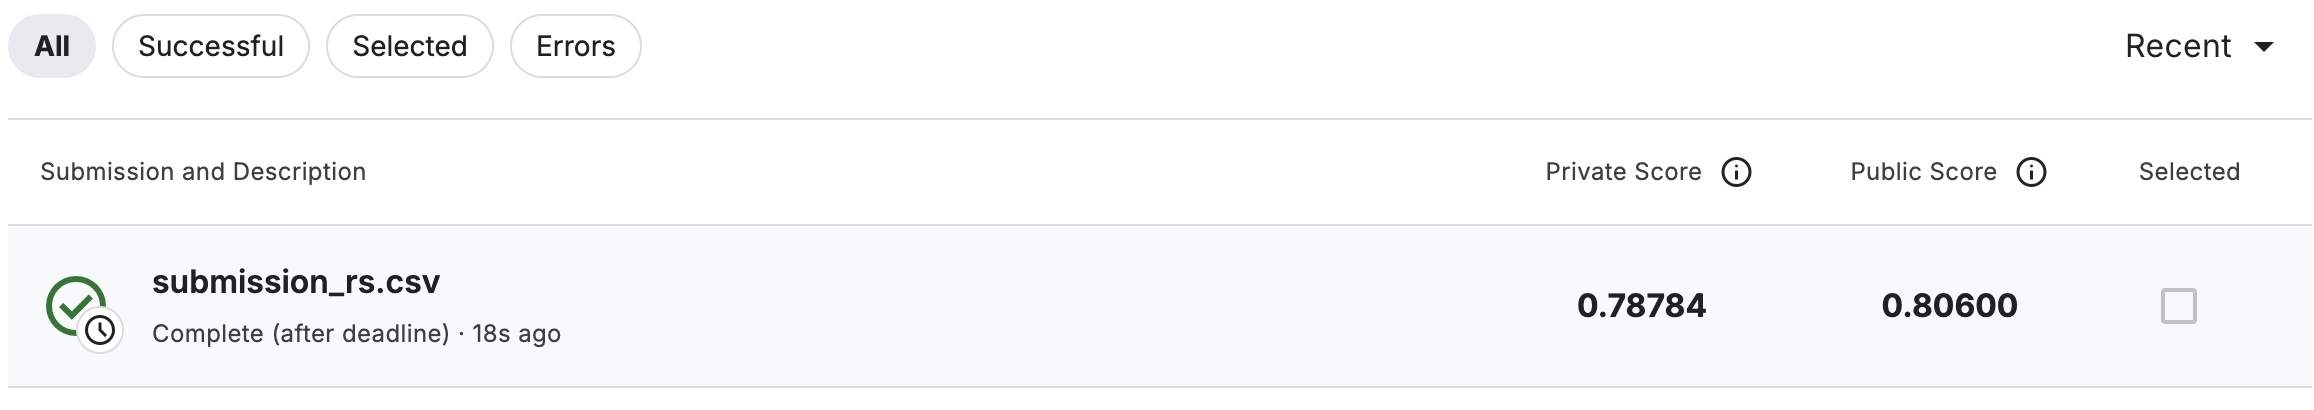